In [165]:
using RigidBodySim
using RigidBodyDynamics


using RigidBodySim

using MechanismGeometries

# # @__NAME__

# PREAMBLE

# PKG_SETUP

# ## Setup

# In addition to `RigidBodyDynamics`, we'll be using the `StaticArrays` package, used throughout `RigidBodyDynamics`, which provides stack-allocated, fixed-size arrays:

using RigidBodyDynamics
using LinearAlgebra
using StaticArrays

function rod_origin_end(length, mass, name)
    frame=CartesianFrame3D(name)
    I_1 = 1 / 3. * mass * length^2   
    c_1 = .5 * length
    inertia1 = SpatialInertia(frame,
        moment=moment=I_1 * SDiagonal(1, 1, 1. / 20^2),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end

function arm(short_length, long_length, mass, name)
    frame=CartesianFrame3D(name)
       
    c_1 = .5(short_length - long_length)
    I_1 = 1 / 12. * mass * (short_length + long_length)^2 + c_1 ^2 * mass
    
    inertia1 = SpatialInertia(frame,
        moment=moment=I_1 * SDiagonal(1, 1, 1. / 20^2),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end

function offset_ball(distance, mass, name)
    frame=CartesianFrame3D(name)
    I_1 =   mass * distance^2   
    I_ball = 2. /5 * mass * (distance / 20)^2
    c_1 = distance
    inertia1 = SpatialInertia(frame,
        moment=moment=SDiagonal(I_1 + I_ball, I_1 + I_ball, I_ball),
        com=SVector(0, 0, c_1),
        mass=mass)
    
    return RigidBody(inertia1)
end
    

function trebuchet_range(arm_length, cw_arm_length, sling_length_1, sling_length_2, flying_weight_mass, do_gui=true)
    g = -.981 # gravitational acceleration in z-direction
    world = RigidBody{Float64}("world")
    doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

    upperlink = arm(cw_arm_length, arm_length, 10 * arm_length / sqrt(2), "upper_link")


    # and a new revolute joint called 'shoulder':
    axis = SVector(1.0, 0, 0)
    shoulder = Joint("shoulder", Revolute(axis))


    # Creating a `Joint` automatically constructs two new `CartesianFrame3D` objects: a frame directly before the joint, and one directly after. To attach the new body to the world by this joint, we'll have to specify where the frame before the joint is located on the parent body (here, the world):

    before_shoulder_to_world = one(Transform3D,
        frame_before(shoulder), default_frame(world))


    # Now we can attach the upper link to the world:

    attach!(doublependulum, world, upperlink, shoulder,
        joint_pose = before_shoulder_to_world)



    lowerlink = offset_ball(1 - cw_arm_length, 1000, "lower_link")
    elbow = Joint("elbow", Revolute(axis))
    before_elbow_to_after_shoulder = Transform3D(
        frame_before(elbow), frame_after(shoulder), SVector(0, 0, cw_arm_length))
    attach!(doublependulum, upperlink, lowerlink, elbow,
        joint_pose = before_elbow_to_after_shoulder)
    
    flying_weight = offset_ball(sling_length_1, flying_weight_mass, "flying_weight")
    
    arm_tip = Joint("arm_tip", Revolute(axis))
    before_tip_to_after_shoulder = Transform3D(
        frame_before(arm_tip), frame_after(shoulder), SVector(0, 0, -arm_length))
    attach!(doublependulum, upperlink, flying_weight, arm_tip,
        joint_pose = before_tip_to_after_shoulder)
    
    
    
    projectile = offset_ball(sling_length_2, 1, "projectile")

    pin = Joint("pin", Revolute(axis))
    before_pin_to_after_fweight = Transform3D(
        frame_before(pin), frame_after(arm_tip), SVector(0, 0, sling_length_2))
    attach!(doublependulum, flying_weight, projectile, pin,
        joint_pose = before_pin_to_after_fweight)

    #add_contact_point!(projectile, center_of_mass(spatial_inertia(projectile)))

    state = MechanismState(doublependulum)


    # Let's first set the configurations and velocities of the joints:

    set_configuration!(state, shoulder, acos(1 / arm_length))
    set_configuration!(state, elbow, pi - acos(1 / arm_length))

    set_configuration!(state, arm_tip,  pi / 2 - acos(1 / arm_length))
    
    set_configuration!(state, pin,  0)

    set_velocity!(state, shoulder, 0)
    set_velocity!(state, elbow, 0)


    setdirty!(state)



    open_loop_dynamics = Dynamics(doublependulum);
    
    problem = ODEProblem(open_loop_dynamics, state, (0., 4))
    
    if(do_gui)
        gui = GUI(doublependulum, Skeleton())
        if !haskey(ENV, "CI") # don't try to open a GUI on a headless CI build
            open(gui)
        end
        vis = gui.visualizer # a MeshCatMechanisms.MechanismVisualizer
        set_configuration!(vis, configuration(state));
        gui_callback = CallbackSet(gui);
        rate_limiter = RealtimeRateLimiter(max_rate = 1)
        callbacks = CallbackSet(gui_callback, rate_limiter) # this is how you combine callbacks
        res = solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.005, callback = callbacks);

    else
        res = solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.005);
    end
    
    #print(length(res), " ")
    
    range = 0
    rs = []
    for t in 0:.05:4
        u = res(t)
        set_configuration!(state, u[1:4])
        set_velocity!(state, u[5:8])
        r = transform_to_root(state, projectile) * center_of_mass(spatial_inertia(projectile))
        push!(rs, [r.v[2], r.v[3]])
        v = point_velocity(
            twist_wrt_world(state, projectile), 
            r
        )
        
        #println(v)
        if(u[3] > 2 * pi || u[3] < -2 * pi)
            break
        end
        if(u[4] > 2 * pi || u[4] < -2 * pi)
            break
        end
        range = max(-v.v[2] * v.v[3] * 2 / g, range)
        
    end
    return range
end

trebuchet_range (generic function with 4 methods)

In [166]:
res = trebuchet_range(sqrt(2), .35, sqrt(2), sqrt(2), 10, true)

453.6324558844167

In [167]:
using BlackBoxOptim

In [168]:
best = bboptimize(;SearchRange = [(1., 5.), (0.05, .95), (0.1, 5.), (0.1, 5.), (1., 100.)], MaxTime=20,
    Method=:xnes) do x
    -trebuchet_range(x[1], x[2], x[3], x[4], x[5], false)
end

t = best_candidate(best)
trebuchet_range(t[1], t[2], t[3], t[4], t[5], true)

Starting optimization with optimizer XNESOpt{Float64,RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
sigma=1.0 |trace(ln_B)|=-8.881784197001252e-16
0.50 secs, 406 evals, 58 steps, fitness=-1184.655902393
sigma=0.5896702158753384 |trace(ln_B)|=8.881784197001252e-16
1.00 secs, 847 evals, 121 steps, fitness=-1647.045819147
sigma=0.3161675259323692 |trace(ln_B)|=1.3322676295501878e-15
1.51 secs, 1281 evals, 183 steps, fitness=-1647.045819147
sigma=0.15360976448979669 |trace(ln_B)|=1.5543122344752192e-15
2.29 secs, 1519 evals, 217 steps, fitness=-1647.045819147
sigma=0.12217233560590168 |trace(ln_B)|=1.7763568394002505e-15
2.80 secs, 1939 evals, 277 steps, fitness=-1647.712158490
sigma=0.0677139964331734 |trace(ln_B)|=3.1086244689504383e-15
3.31 secs, 2338 evals, 334 steps, fitness=-1691.555821346
sigma=0.042149199461039066 |trace(ln_B)|=3.774758283725532e-15
3.81 secs, 2730 evals, 390 steps, fitness=-1693.750587067
sigma=0.021972945524512795 |trace(ln_B)|=7.549516567451

1691.231942440192

In [162]:
trebuchet_range(t[1], t[2], t[3], t[4], t[5], true)

1815.7767514737147

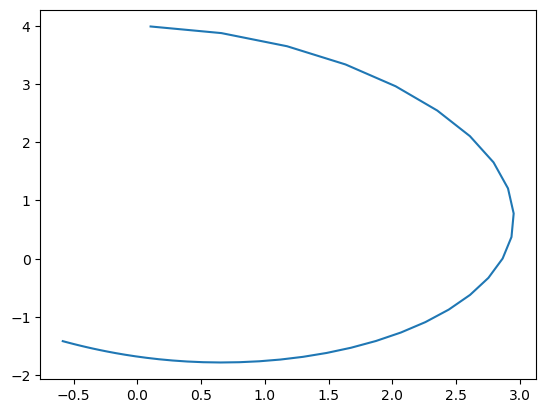

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006EAF0EB8>

In [121]:
r = hcat(rs...)
using PyPlot
plot(r[1, :], r[2, :])


In [43]:
res(3.6)

6-element Array{Float64,1}:
  3.5718601570305855
  0.1311088612336846
 10.443131571413554 
 -1.8555771385859818
  3.432031833222224 
  6.744510638326981 

In [66]:
import AtlasRobot

mechanism = AtlasRobot.mechanism(add_flat_ground=true)

state = MechanismState(mechanism)


# Let's first set the configurations and velocities of the joints:
AtlasRobot.setnominal!(state)
setdirty!(state)



using RigidBodySim

using MechanismGeometries
open_loop_dynamics = Dynamics(mechanism);

gui = GUI(mechanism, Skeleton())
if !haskey(ENV, "CI") # don't try to open a GUI on a headless CI build
    open(gui)
end
vis = gui.visualizer # a MeshCatMechanisms.MechanismVisualizer
set_configuration!(vis, configuration(state));
gui_callback = CallbackSet(gui);
problem = ODEProblem(open_loop_dynamics, state, (0., 5.))
rate_limiter = RealtimeRateLimiter(max_rate = 1.)
callbacks = CallbackSet(gui_callback, rate_limiter) # this is how you combine callbacks
solve(problem, Tsit5(), abs_tol = 1e-10, dt = 0.05, callback = callbacks);

In [1]:
3

3

In [58]:
Pkg.add("AtlasRobot")

 Resolving package versions...
 Installed AtlasRobot ─ v0.4.0
  Updating `C:\Users\hasti\.julia\environments\v1.1\Project.toml`
  [436ed74b] + AtlasRobot v0.4.0
  Updating `C:\Users\hasti\.julia\environments\v1.1\Manifest.toml`
  [436ed74b] + AtlasRobot v0.4.0
  Building AtlasRobot → `C:\Users\hasti\.julia\packages\AtlasRobot\iQG8w\deps\build.log`
